In [ ]:
#!pip install hume

zsh:1: /Users/Parzon/opt/anaconda3/bin/pip: bad interpreter: /Users/macbook/opt/anaconda3/bin/python: no such file or directory
  Using cached hume-0.7.2-py3-none-any.whl.metadata (9.1 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
Using cached hume-0.7.2-py3-none-any.whl (290 kB)
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
Using cached eval_type_backport-0.2.0-py3-none-any.whl (5.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.2 MB/s eta 0:00:00a 0:00:01


In [ ]:
# %pip install matplotlib
# %pip install numpy
# %pip install pandas



  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 8.5 MB/s eta 0:00:00a 0:00:01m
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 8.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/processed_audio/audio_3_session_1732532770_chunk_0_20241125164727.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/processed_audio/audio_5_session_1732532770_chunk_0_20241125164738.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/processed_audio/audio_2_session_1732532770_chunk_0_20241125164722.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/processed_audio/audio_4_session_1732532770_chunk_0_20241125165822.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/processed_audio/audio_5_session_1732532770_chunk_0_20241125165827.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciou

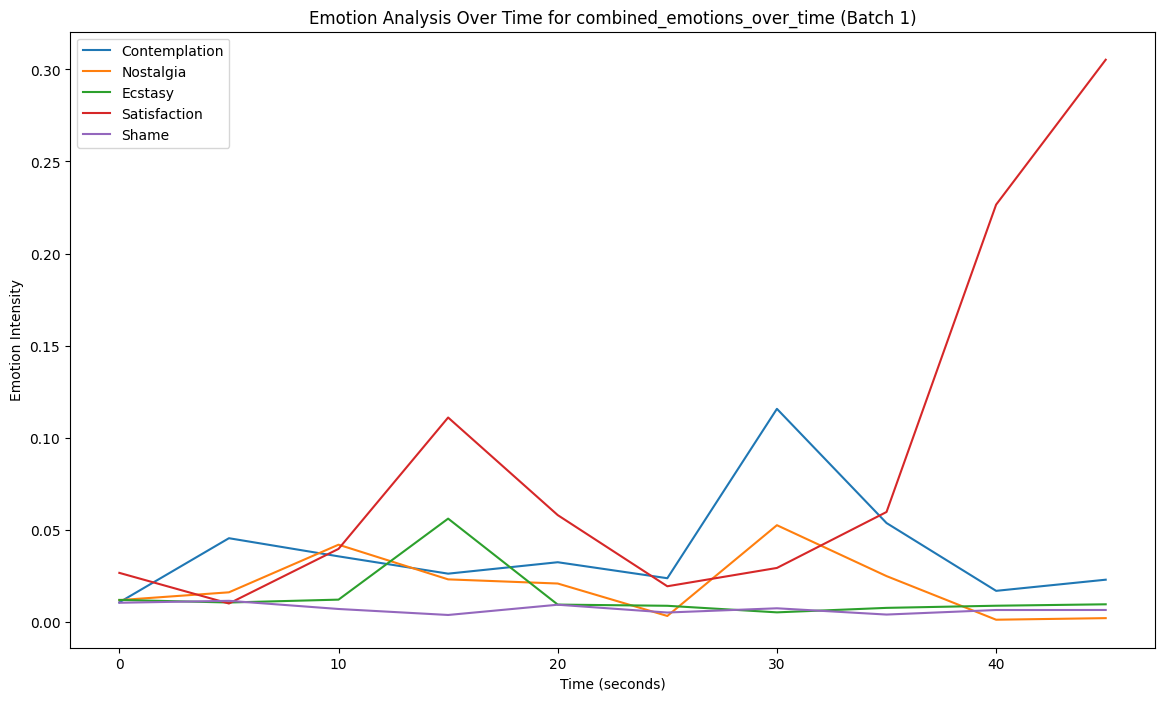

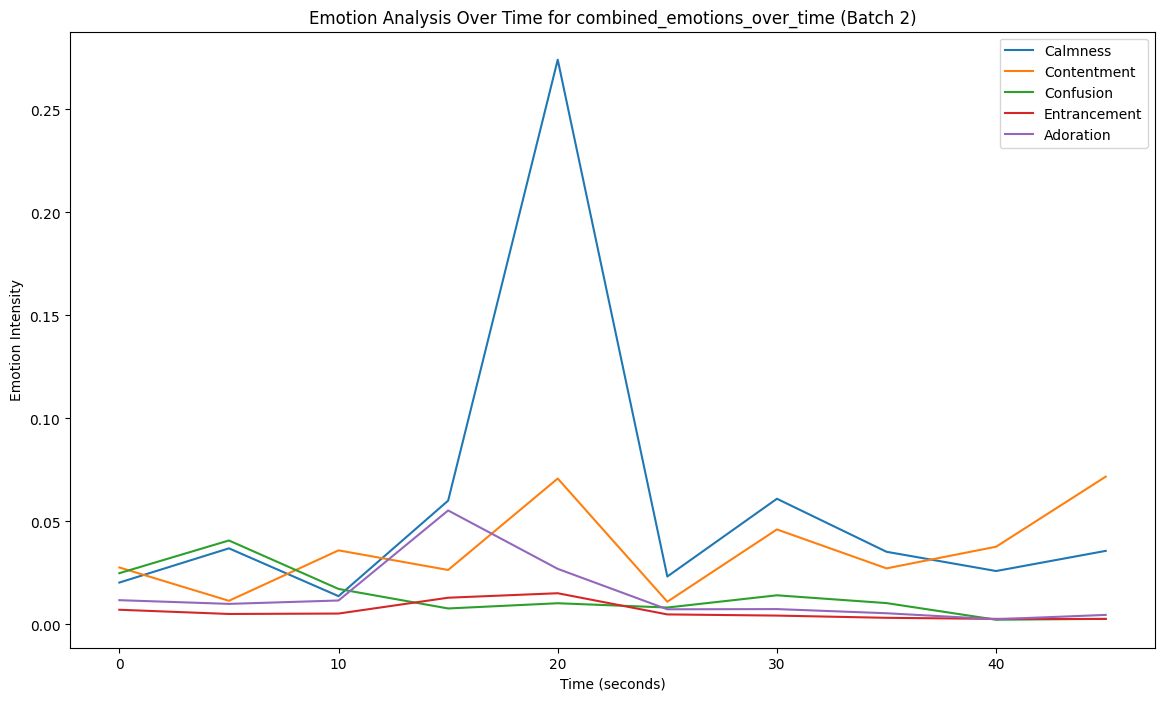

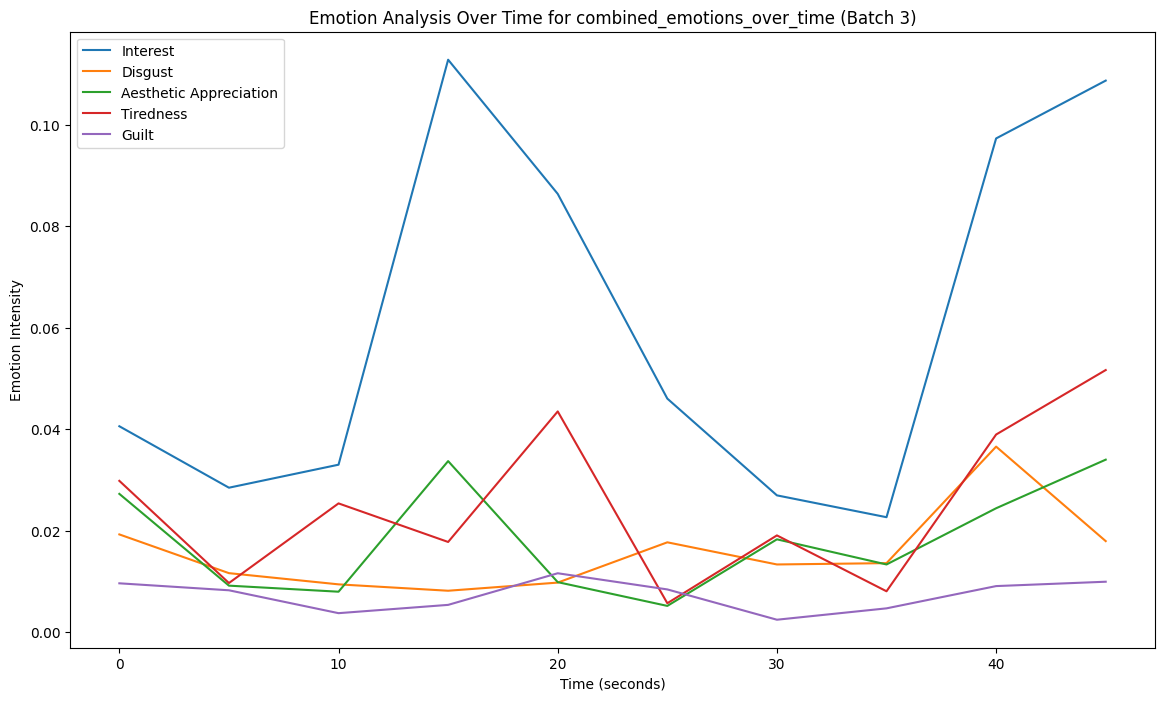

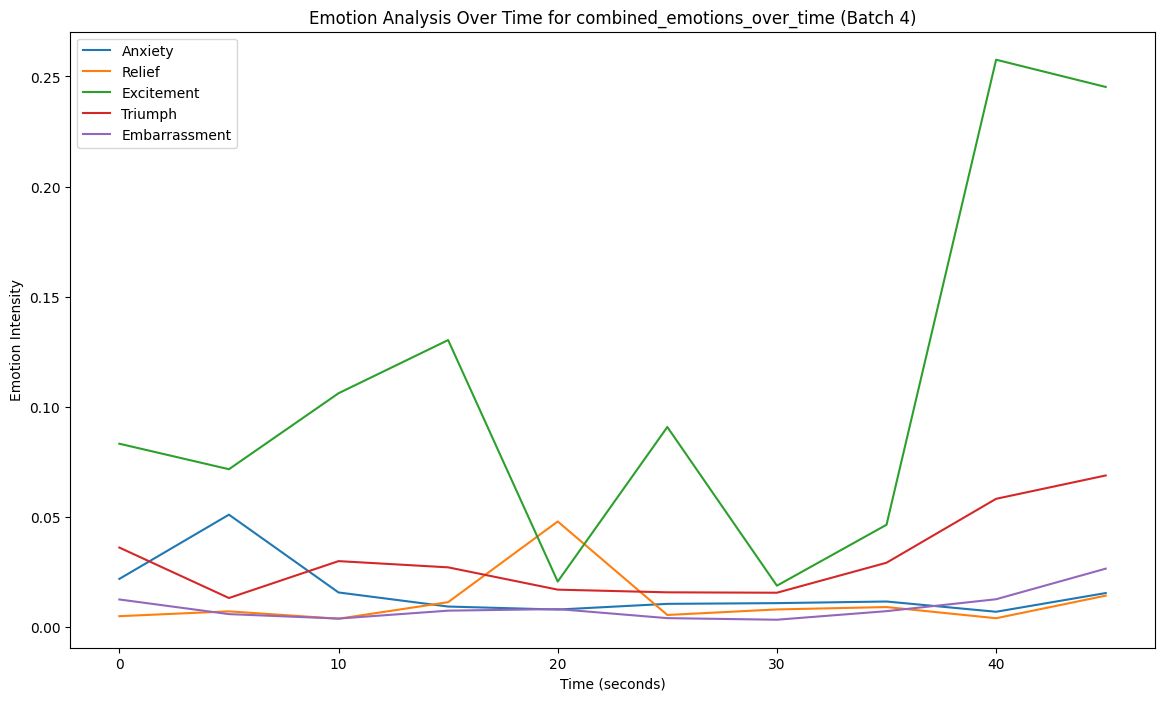

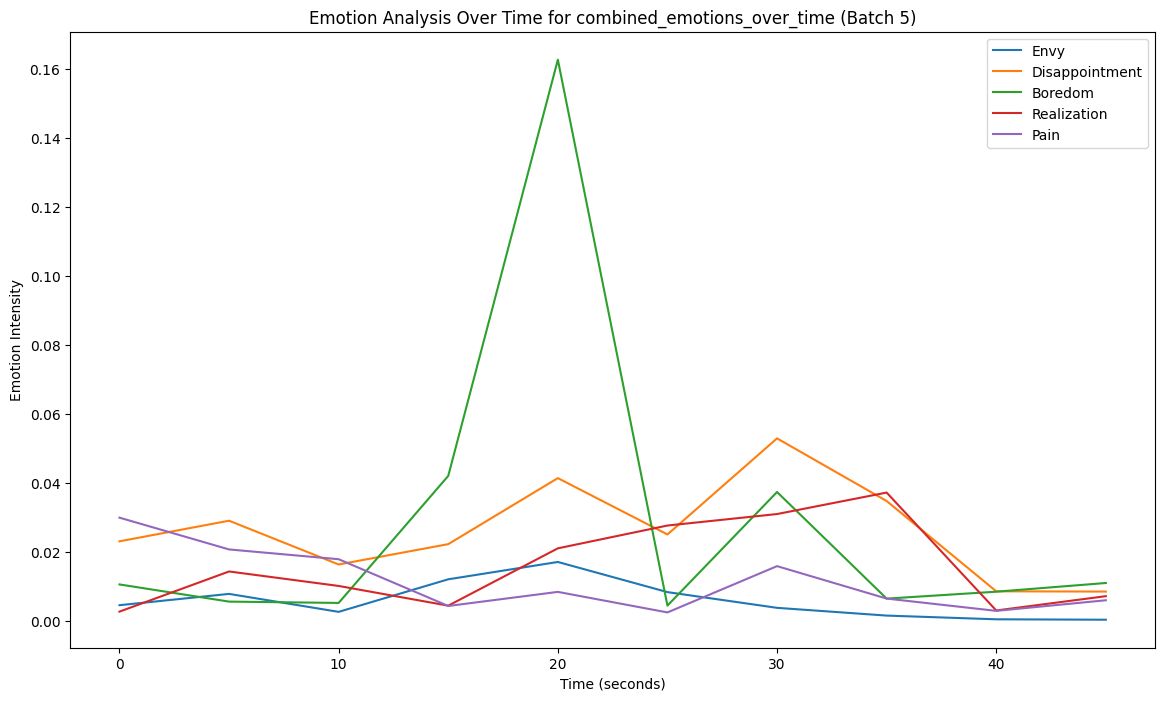

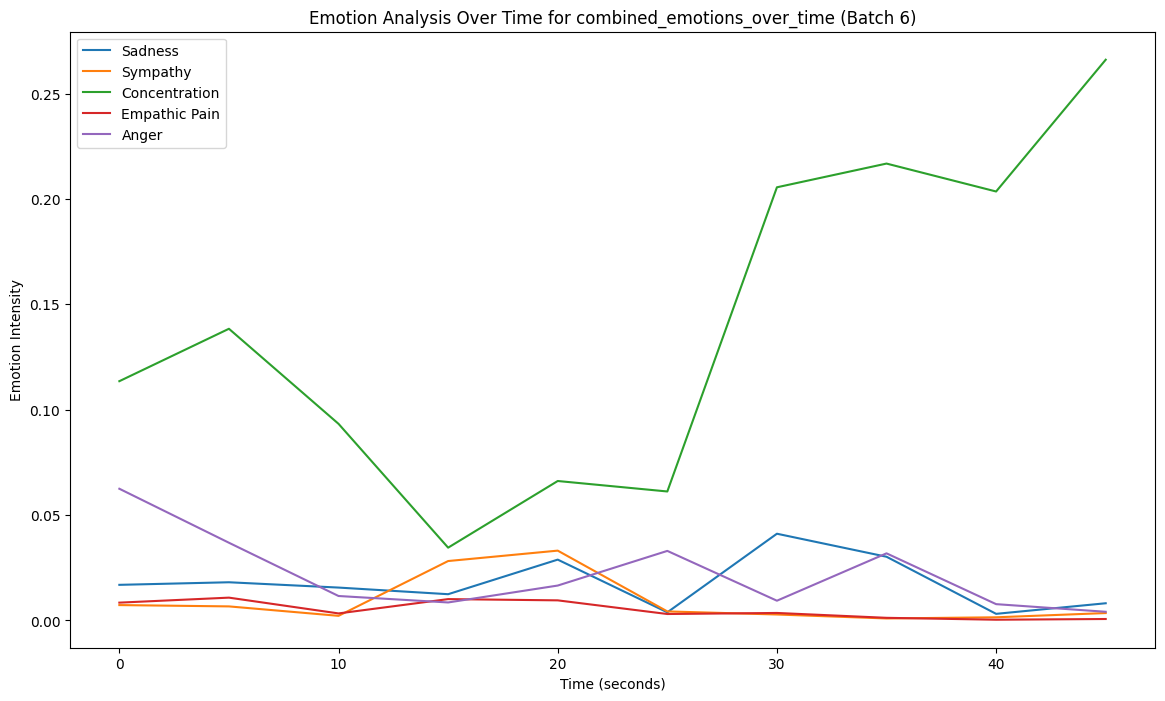

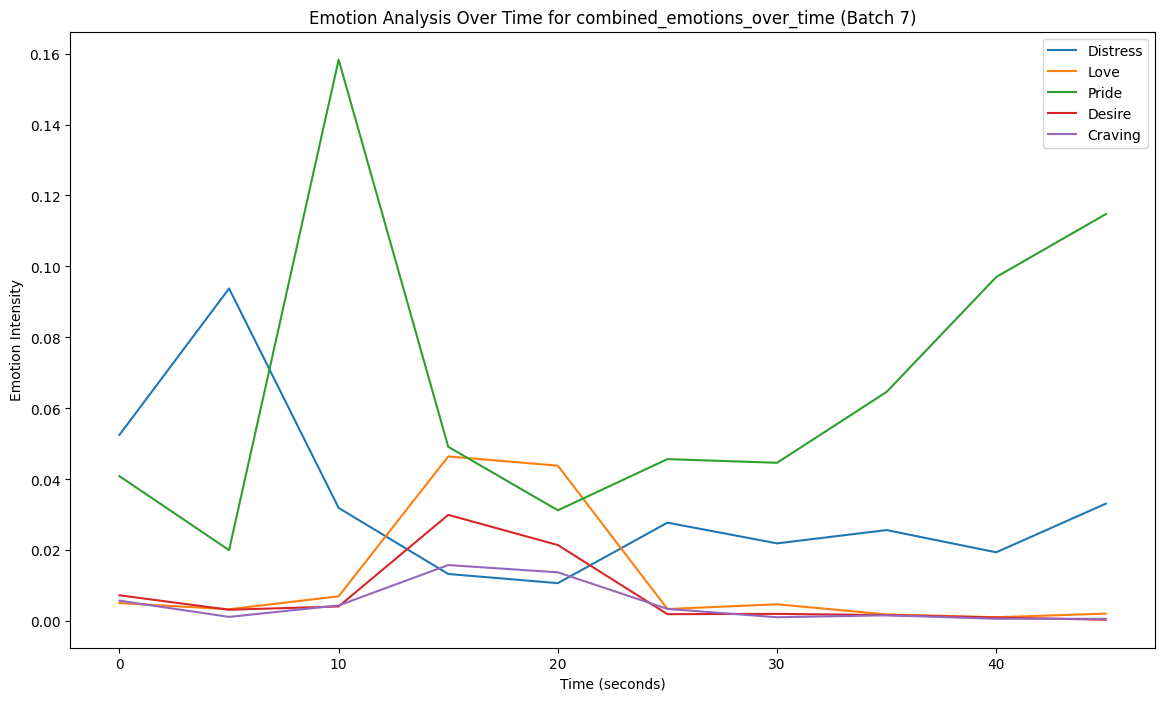

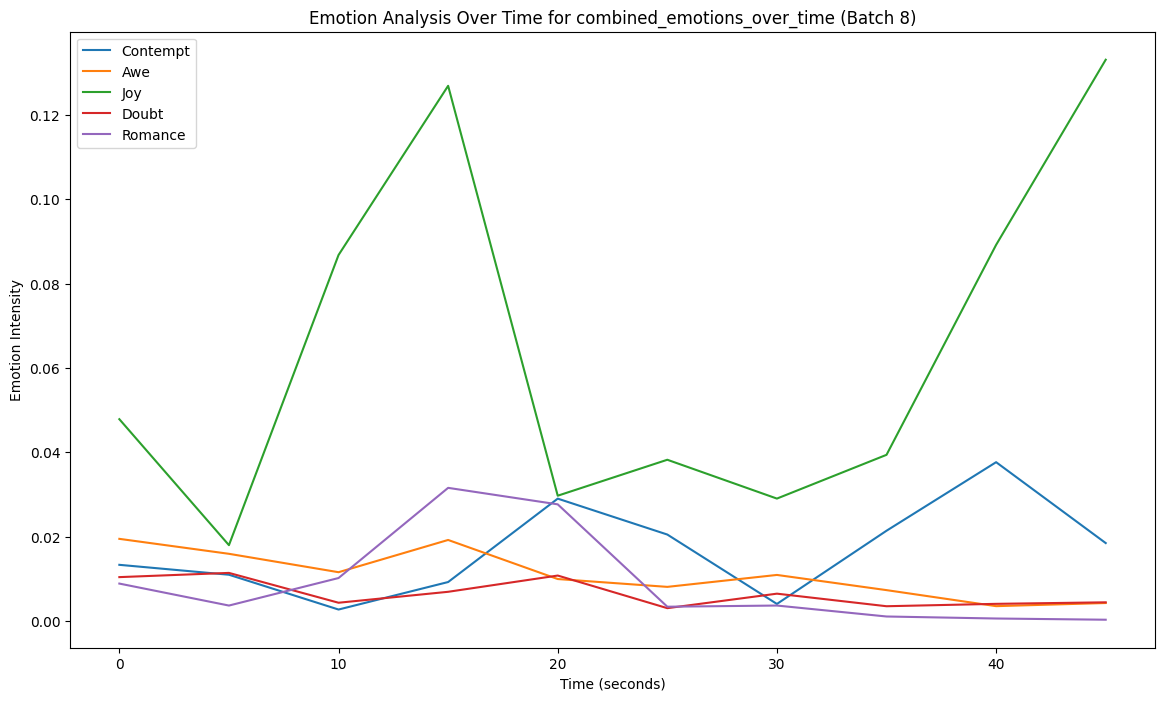

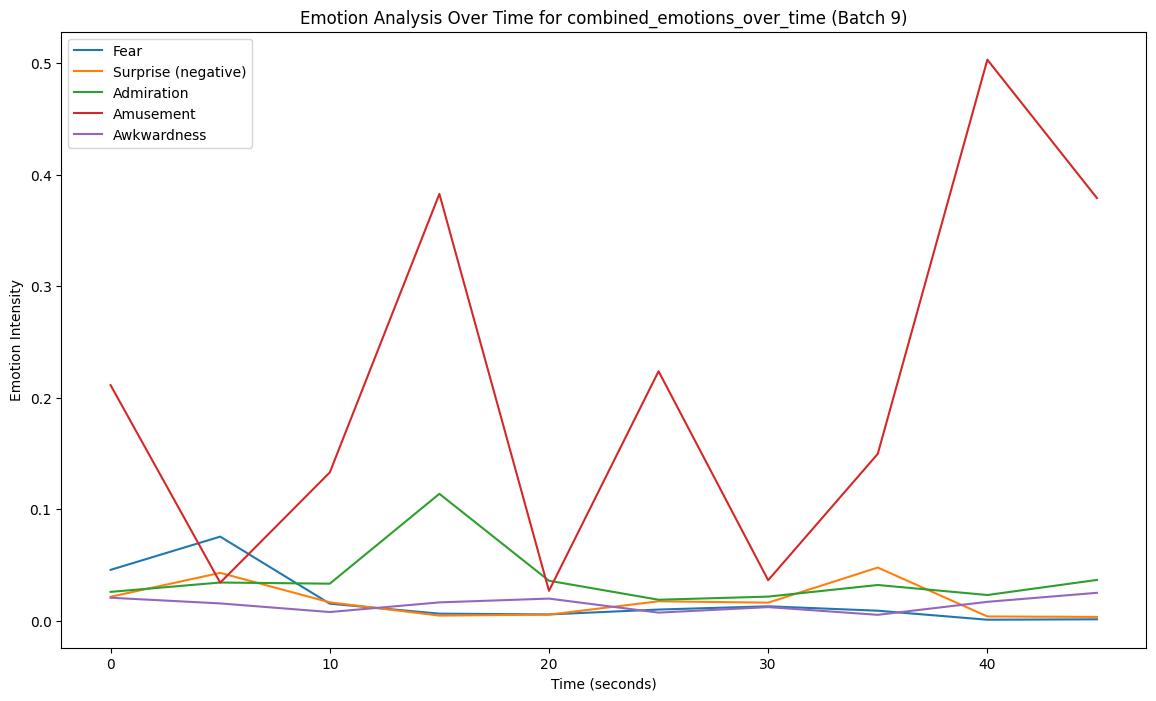

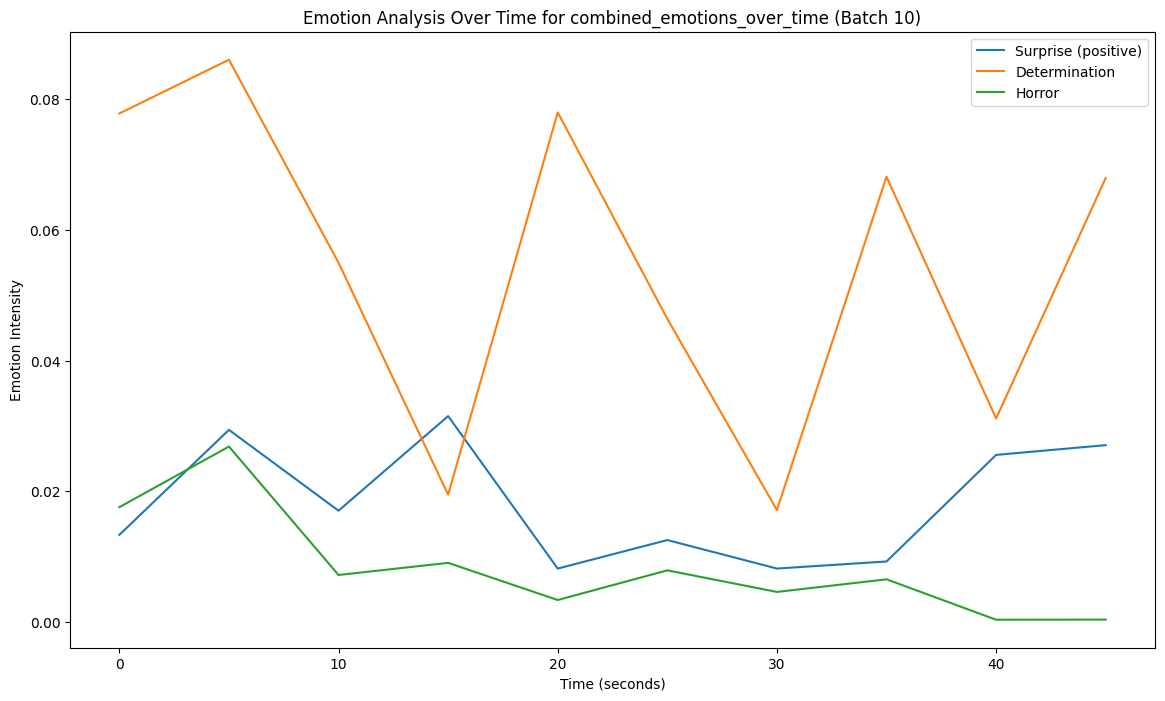

In [1]:
import os
import asyncio
import json
import logging
import matplotlib.pyplot as plt
from hume.client import AsyncHumeClient
from hume.expression_measurement.stream import Config
from hume.expression_measurement.stream.socket_client import StreamConnectOptions
import nest_asyncio

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up your API key
API_KEY = "sQp9AtmP52EQ5kD1AG9aQxYfZgrkPvwrOKGZZAxaZAqbynvv"

# Perform Hume emotion analysis on a given audio file
async def analyze_audio(file_path):
    client = AsyncHumeClient(api_key=API_KEY)
    model_config = Config(prosody={})
    stream_options = StreamConnectOptions(config=model_config)

    retries = 3
    for attempt in range(retries):
        try:
            async with client.expression_measurement.stream.connect(options=stream_options) as socket:
                result = await socket.send_file(file_path)
                if hasattr(result, "prosody"):
                    return result.prosody.predictions
                else:
                    logger.error(f"Unexpected response type: {type(result)}. Response: {result}")
                    return None
        except Exception as e:
            logger.error(f"Error during audio analysis (attempt {attempt + 1}): {e}")
            if attempt < retries - 1:
                await asyncio.sleep(2 ** attempt)
            else:
                logger.error("Exceeded maximum retries for audio analysis.")
                return None

# Plot emotional analysis over time for all emotions in groups of 5
def plot_emotions_over_time(prosody_data, file_name, save_json=True):
    if not prosody_data:
        print(f"No prosody data to plot for {file_name}.")
        return

    # Save prosody data as JSON
    if save_json:
        with open(f"{file_name}_emotions.json", "w") as json_file:
            json.dump([{
                "time": {
                    "begin": prediction.time.begin,
                    "end": prediction.time.end
                },
                "emotions": [
                    {
                        "name": emotion.name,
                        "score": emotion.score
                    } for emotion in prediction.emotions
                ]
            } for prediction in prosody_data], json_file, indent=4)

    # Extract all emotion names
    all_emotions = set()
    for prediction in prosody_data:
        for emotion in prediction.emotions:
            all_emotions.add(emotion.name)
    all_emotions = list(all_emotions)

    # Consolidate time across all files
    time_points = []
    for idx, prediction in enumerate(prosody_data):
        time_points.append(idx * 5)  # Assuming each prediction covers a 5-second span

    # Plot emotions in groups of 5
    batch_size = 5
    batch_counter = 1
    for i in range(0, len(all_emotions), batch_size):
        selected_emotions = all_emotions[i:i + batch_size]
        emotion_values = {emotion: [0] * len(time_points) for emotion in selected_emotions}

        for idx, prediction in enumerate(prosody_data):
            for emotion in prediction.emotions:
                if emotion.name in selected_emotions:
                    emotion_values[emotion.name][idx] = emotion.score

        plt.figure(figsize=(14, 8))
        for emotion in selected_emotions:
            plt.plot(time_points, emotion_values[emotion], label=emotion)

        plt.xlabel("Time (seconds)")
        plt.ylabel("Emotion Intensity")
        plt.title(f"Emotion Analysis Over Time for {file_name} (Batch {batch_counter})")
        plt.legend()
        plt.savefig(f"{file_name}_batch_{batch_counter}.png")
        plt.show()
        plt.close()

        batch_counter += 1

# Main function to process all WAV files in a folder and save plots and JSONs
async def process_audio_folder(folder_path):
    wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    if not wav_files:
        print("No WAV files found in the specified folder.")
        return

    combined_prosody_data = []
    for wav_file in wav_files:
        file_path = os.path.join(folder_path, wav_file)
        print(f"Processing file: {file_path}")
        analysis_result = await analyze_audio(file_path)
        if analysis_result:
            combined_prosody_data.extend(analysis_result)
        else:
            print(f"Failed to analyze audio for {wav_file}.")

    if combined_prosody_data:
        plot_emotions_over_time(combined_prosody_data, "combined_emotions_over_time")

if __name__ == "__main__":
    # Change this path to the appropriate folder containing your WAV files
    wav_folder_path = "/Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/processed_audio"
    nest_asyncio.apply()  # To prevent event loop running error in Jupyter-like environments

    loop = asyncio.get_event_loop()
    loop.run_until_complete(process_audio_folder(wav_folder_path))


In [1]:
import os
secret_key = os.urandom(24)
print(secret_key)


b'\x9c!hV\xfa\xea\xba\xcf\x1a\x84s\xa0A\xa3\xbeodw\xd2\x92P6\xdb\xd9'


In [ ]:
# %pip install nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [23]:
import asyncio
import nest_asyncio
import cv2
import pandas as pd
from hume import AsyncHumeClient
from hume.expression_measurement.stream import Config
from hume.expression_measurement.stream.socket_client import StreamConnectOptions
from hume.expression_measurement.stream.types import StreamFace
from datetime import datetime
import base64
from pathlib import Path
import time
import os

# Apply nest_asyncio to allow running the asyncio event loop in Jupyter
nest_asyncio.apply()

# Initialize a DataFrame to store the initial mood
columns = ['Username', 'Initial Mood', 'Timestamp']
mood_df = pd.DataFrame(columns=columns)

# Function to base64 encode the image
def encode_image(image_path: str):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_image

# Function to process face and get results from Hume
async def process_face(image_path: str, username: str):
    client = AsyncHumeClient(api_key="sQp9AtmP52EQ5kD1AG9aQxYfZgrkPvwrOKGZZAxaZAqbynvv")  # Use your actual Hume API key

    model_config = Config(face=StreamFace())
    stream_options = StreamConnectOptions(config=model_config)

    # Using the async context manager to manage the connection
    async with client.expression_measurement.stream.connect(options=stream_options) as socket:
        encoded_image = encode_image(image_path)
        
        # Sending the base64-encoded image to Hume's API for analysis
        result = await socket.send_file(encoded_image)  # Use send_file to send image data
        
        print("Result received from Hume: ", result)

        # Directly access 'face' and 'predictions' attributes
        face_predictions = result.face.predictions if result.face else None

        if face_predictions:
            # Extract emotions from predictions and sort by score
            emotions = face_predictions[0].emotions if face_predictions else []
            emotions_sorted = sorted(emotions, key=lambda e: e.score, reverse=True)  # Sort by score descending
            
            # Get the top 5 emotions with their scores
            top_5_emotions = [(e.name, e.score) for e in emotions_sorted[:5]]  # List of tuples (emotion, score)
            timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

            # Store the username, initial mood (emotions and scores), and timestamp in the DataFrame
            global mood_df
            top_5_emotions_str = ', '.join([f"{name}: {score:.2f}" for name, score in top_5_emotions])  # Format emotions with scores
            new_row = pd.DataFrame([{'Username': username, 'Initial Mood': top_5_emotions_str, 'Timestamp': timestamp}])
            mood_df = pd.concat([mood_df, new_row], ignore_index=True)
            print(f"Top 5 Emotions for {username}: {top_5_emotions_str} recorded at {timestamp}")
        else:
            print("No face detected. Retrying...")

        return mood_df  # Return the updated DataFrame with the initial mood

# Function to start the camera and capture the image until a face is detected
def capture_face_until_detected(username: str):
    cap = cv2.VideoCapture(0)  # Open the camera

    # Load the Haar cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    start_time = time.time()  # Record the start time
    timeout = 20  # Timeout in seconds

    upload_dir = "/Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_images"
    if not os.path.exists(upload_dir):
        os.makedirs(upload_dir)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame. Exiting...")
            break

        # Convert the frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        # Check if any faces are detected
        if len(faces) > 0:
            for (x, y, w, h) in faces:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Save the captured frame if a face is detected
            filename = f"{upload_dir}/captured_face.png"
            cv2.imwrite(filename, frame)

            # Process the captured image using Hume's API
            print(f"Captured face image saved as: {filename}")
            loop = asyncio.get_event_loop()
            mood_df = loop.run_until_complete(process_face(filename, username))  # Process the face and get emotions

            # If face is detected and processed, break the loop
            if len(mood_df) > 0:
                break
        else:
            print("No face detected. Trying again...")

        # Check if 20 seconds have passed
        if time.time() - start_time > timeout:
            print("Timeout reached. No face detected.")
            break

    cap.release()
    cv2.destroyAllWindows()  # Ensure all OpenCV windows are closed
    return mood_df

# Function to run the async code and capture the face
def run_capture_and_process(username: str):
    mood_df = capture_face_until_detected(username)
    if not mood_df.empty:
        print(mood_df)
    else:
        print("No mood data was recorded.")

# Example usage
username = "parzon"  # Replace with the actual username
run_capture_and_process(username)


No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detected. Trying again...
No face detect

In [24]:
mood_df

,Username,Initial Mood,Timestamp
0,parzon,"Concentration: 0.52, Boredom: 0.45, Calmness: ...",2024-11-11 22:45:56
